# Initialize all data structures

In [14]:
import pandas as pd
df = pd.read_csv("data/upc_sales.csv")

# Stores
df_stores = pd.read_csv("data/stores.csv")

# DEMO data
df["DATE"] = pd.to_datetime(df["DATE"])
df["WEEK"] = df['DATE'].dt.to_period('W').dt.to_timestamp()

df = pd.merge(df, df_stores, left_on="STOREID", right_on="STORE_ID", how="inner")
df.rename(columns={"RETAILER_ID_x":"RETAILER_ID", "CITY":"PPG"},inplace=True)
df.drop(columns=["RETAILER_ID_y","STORE_NAME","STORE_ID"],inplace=True)

# Group
df_grouped_volume = df.groupby(["UPC","RETAILER_ID","PPG","WEEK"]).agg(
    {"qty":"sum","mean_unit_price_rounded":"mean"}).reset_index()

df_grouped_volume.rename(columns={"mean_unit_price_rounded":"mean_unit_price"},inplace=True)
df_grouped_volume.set_index("WEEK",inplace=True)

# UPC list
df_use_case_upcs = pd.read_csv("data/input_upcs - synthetic-usecases.csv")

print(f"No of columns in DEMO --> {len(df.columns)}")


No of columns in DEMO --> 9


# INPUT UPC

In [15]:
MYUPC = 987654321

In [18]:
import numpy as np

df_use_cases_upcs_current = df_use_case_upcs[df_use_case_upcs["UPC"]==MYUPC]
RETAILER_ID = df_use_cases_upcs_current["RETAILER_ID"].values[0]
PPG = df_use_cases_upcs_current["PPG"].values[0]

print(f"Retailer --> {RETAILER_ID}, PPG --> {PPG}")

df_upc_grouped = df_grouped_volume[(df_grouped_volume["UPC"]==MYUPC)
                           &(df_grouped_volume["RETAILER_ID"]==RETAILER_ID)
                           &(df_grouped_volume["PPG"]==PPG)]

df_upc = df_upc_grouped[["qty","mean_unit_price"]]

df_upc = df_upc.asfreq('W',method="ffill")

df_upc["Logqty"] = np.log(df_upc["qty"])

df_upc

Retailer --> 3, PPG --> COLUMBIA


,qty,mean_unit_price,Logqty
WEEK,,,
2017-01-01,15.0,4.000000,2.708050
2017-01-08,186.0,4.495413,5.225747
2017-01-15,196.0,4.598291,5.278115
2017-01-22,169.0,3.980392,5.129899
2017-01-29,169.0,3.967742,5.129899
...,...,...,...
2021-05-16,156.0,4.234568,5.049856
2021-05-23,101.0,4.295082,4.615121
2021-05-30,129.0,4.303797,4.859812


# PLOT, FIT & FORECAST
 - and get to the model (not there in the below code)
 - Assumption here is you already know (p, d, q) & (P,D,Q,M)

/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.19289D+00    |proj g|=  2.53243D-02


 This problem is unconstrained.



At iterate    5    f=  5.18442D+00    |proj g|=  5.98928D-03

At iterate   10    f=  5.18420D+00    |proj g|=  4.23196D-03

At iterate   15    f=  5.17616D+00    |proj g|=  1.50261D-02

At iterate   20    f=  5.16701D+00    |proj g|=  3.72331D-04

At iterate   25    f=  5.16658D+00    |proj g|=  1.75614D-02

At iterate   30    f=  5.16376D+00    |proj g|=  1.56730D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     39      1     0     0   5.852D-06   5.164D+00
  F =   5.1637519178455724     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
MSE:  38840.52512094705
AIC:  2416.308393716037
SSE

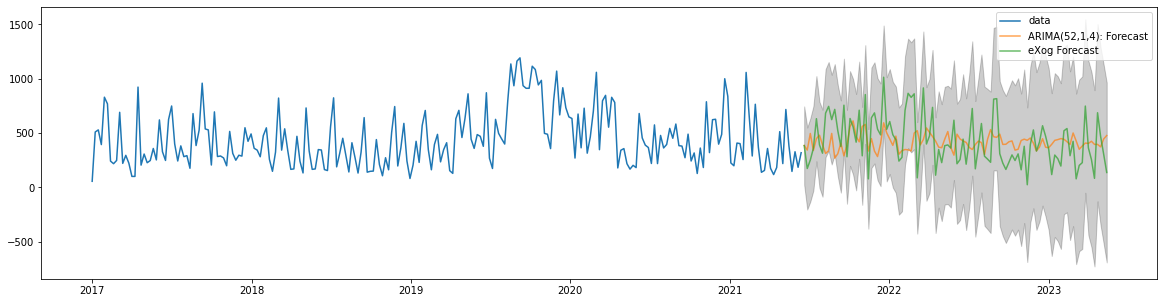

In [4]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

FORECAST_STEPS = 12
FORECAST_START = "2021-06-20"
FORECAST_END = "2023-05-14"

## ARIMA 

from statsmodels.tsa.arima.model import ARIMA



Ntest = 12
train = df_upc.iloc[:-Ntest]
test = df_upc.iloc[-Ntest:]

train_idx = df_upc.index <= train.index[-1]
test_idx = df_upc.index > train.index[-1]

arima = ARIMA(train["Logqty"], order=(52,1,4))
arima_result_log5214 = arima.fit()

# predict_arima_result_log5214 = arima_result_log5214.get_forecast(FORECAST_STEPS)
predict_arima_result_log5214 = arima_result_log5214.get_prediction(start=FORECAST_START, end=FORECAST_END)



## SARIMAX EXOG
exog_mod = sm.tsa.statespace.SARIMAX(df_upc["qty"],exog=df_upc["mean_unit_price"],
                                order=(1,1,1),
                                seasonal_order=(1,1,0,52),)

exog_results = exog_mod.fit()

# Performance metrics
print("MSE: ", exog_results.mse)
print("AIC: ", exog_results.aic)
print("SSE: ", exog_results.sse)

exog_forecast_prices = df_upc["mean_unit_price"].sample(FORECAST_STEPS).to_list()
exog_forecast_prices

exog_results.get_prediction()

# exog_pred = exog_results.get_forecast(FORECAST_STEPS, exog=exog_forecast_prices)
exog_pred = exog_results.get_prediction(start=FORECAST_START, end=FORECAST_END, exog=exog_forecast_prices)
exog_pred_ci = exog_pred.conf_int()

fig, ax = plt.subplots(figsize=(20,5))
ax.plot(df_upc["qty"].index, df_upc["qty"], label="data")

ax.plot(predict_arima_result_log5214.conf_int().index, np.exp(predict_arima_result_log5214.predicted_mean), 
        label='ARIMA(52,1,4): Forecast', alpha=.7)

ax.plot(exog_pred_ci.index, exog_pred.predicted_mean, label='eXog Forecast', alpha=.7)

ax.fill_between(exog_pred_ci.index,
                exog_pred_ci["lower qty"],
                exog_pred_ci["upper qty"], color='k', alpha=.2)


ax.legend()

In [6]:

import numpy as np
import pandas as pd

unioned_index = df_upc_grouped.index.union(exog_results.get_forecast(FORECAST_STEPS, exog=exog_forecast_prices).conf_int().index)
df_upc_grouped = df_upc_grouped.reindex(index=unioned_index)

df_upc_grouped["SARIMAX forecasted"] = exog_results.get_forecast(FORECAST_STEPS, exog=exog_forecast_prices).predicted_mean
df_upc_grouped["SARIMAX conf lower qty"] = exog_results.get_forecast(FORECAST_STEPS, exog=exog_forecast_prices).conf_int()["lower qty"]
df_upc_grouped["SARIMAX conf upper qty"] = exog_results.get_forecast(FORECAST_STEPS, exog=exog_forecast_prices).conf_int()["upper qty"]


df_upc_grouped["ARIMA log forecasted"] = np.exp(arima_result_log5214.get_forecast(FORECAST_STEPS).predicted_mean)
df_upc_grouped["ARIMA log conf lower qty"] =  np.exp(arima_result_log5214.get_forecast(FORECAST_STEPS).conf_int()["lower Logqty"])
df_upc_grouped["ARIMA log conf upper qty"] = np.exp(arima_result_log5214.get_forecast(FORECAST_STEPS).conf_int()["upper Logqty"])

# Create the dataframe with datetimeindex for price forecast
price_forecast_df = pd.DataFrame(index=exog_results.get_forecast(FORECAST_STEPS, exog=exog_forecast_prices).conf_int().index, 
             data={"mean_unit_price":exog_forecast_prices})

df_upc_grouped.loc[pd.to_datetime(FORECAST_START):pd.to_datetime(FORECAST_END)]["mean_unit_price"] = price_forecast_df.loc[pd.to_datetime(FORECAST_START):pd.to_datetime(FORECAST_END)]["mean_unit_price"]

df_upc_grouped["WEEK"] = df_upc_grouped.index.to_series()
# print(df_upc_grouped)
df_upc_grouped.to_csv("/home/ubuntu/temp/VISUALIZATION_DATA/SAMPLE_ARIMA_SARIMAX_OUTPUT.csv", index=False)


                     UPC  RETAILER_ID        PPG    qty  mean_unit_price  \
2016-12-26  1.200000e+09          2.0  LAKE CITY   56.0         2.000000   
2017-01-02  1.200000e+09          2.0  LAKE CITY  510.0         1.000000   
2017-01-09  1.200000e+09          2.0  LAKE CITY  529.0         1.000000   
2017-01-16  1.200000e+09          2.0  LAKE CITY  394.0         1.000000   
2017-01-23  1.200000e+09          2.0  LAKE CITY  830.0         1.000000   
...                  ...          ...        ...    ...              ...   
2023-04-16           NaN          NaN        NaN    NaN         2.000000   
2023-04-23           NaN          NaN        NaN    NaN         1.285714   
2023-04-30           NaN          NaN        NaN    NaN         1.285714   
2023-05-07           NaN          NaN        NaN    NaN         2.000000   
2023-05-14           NaN          NaN        NaN    NaN         2.000000   

            SARIMAX forecasted  SARIMAX conf lower qty  \
2016-12-26                 Na

/tmp/ipykernel_803406/1215950657.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_upc_grouped.loc[pd.to_datetime(FORECAST_START):pd.to_datetime(FORECAST_END)]["mean_unit_price"] = price_forecast_df.loc[pd.to_datetime(FORECAST_START):pd.to_datetime(FORECAST_END)]["mean_unit_price"]


## Correlation between Qty and Price

In [9]:
BEFORE_CORR = df_upc_grouped.loc[pd.to_datetime("2016-12-26"):pd.to_datetime(FORECAST_START)]["mean_unit_price"].corr(
    df_upc_grouped.loc[pd.to_datetime("2016-12-26"):pd.to_datetime(FORECAST_START)]["qty"])

FORECAST_CORR = df_upc_grouped.loc[pd.to_datetime(FORECAST_START):pd.to_datetime(FORECAST_END)]["mean_unit_price"].corr(
    df_upc_grouped.loc[pd.to_datetime(FORECAST_START):pd.to_datetime(FORECAST_END)]["SARIMAX forecasted"])

print(f"Before forecast CORR -->{BEFORE_CORR} , After forecast CORR -->{FORECAST_CORR}")

Before forecast CORR -->-0.7261788811069857 , After forecast CORR -->-0.7919610552894615


## Correlation between ARIMA & SARIMAX

In [10]:
ARIMA_SARIMAX_CORR = df_upc_grouped.loc[pd.to_datetime(FORECAST_START):pd.to_datetime(FORECAST_END)]["ARIMA log forecasted"].corr(
    df_upc_grouped.loc[pd.to_datetime(FORECAST_START):pd.to_datetime(FORECAST_END)]["SARIMAX forecasted"])

print(f"ARIMA vs. SARIMAX CORR -->{ARIMA_SARIMAX_CORR}")

ARIMA vs. SARIMAX CORR -->0.059744588439232416
